This model is for demonstration purposes only. Please contact the creator to obtain permission for use or distribution via email at Nicolasneuralnetworks@proton.me.

---
## A TensorFlow NLP CNN Model for Identifying Manifestos of Concern. ##

**Objective:**

This natural language processing (NLP) model aims to identify manifestos posted prior to an event of concern. A manifesto is a text expressing the ideology, intentions, and motivations of an individual or organization. Manifestos are often posted online before school shootings and politically motivated mass shootings. Correctly identifying problematic manifestos is crucial as it can signal and potentially disrupt large-scale security events. Limiting the distribution of manifestos is also imperative, given their history as motivational bases for other incidents.

**The Dataset:**

An effective NLP model must identify specific and unique language attributes. To create a robust dataset, we replicated themes and language from environments where manifestos of concern are typically shared, like 4chan and Reddit. While large hate detection datasets exist, their validity is questionable, as they often include content that doesn't represent far-right ideology, as such a custom dataset was created.

The key features typically seen in manifestos of concern are:

Mental health (particularly depression, OCD, and anxiety)
Suicidality
Social Isolation
Components of Incel ideology
Antisemitism
Fascism
Opposition to authority

These themes were captured by sampling datasets from:

Reddit Mental Health data sets (covering depression, OCD, suicidality, anxiety)
Incel forums
Parler
4Chan
Iron March
Preprocessing

150 to 250 rows of data were sampled at random from each dataset using pandas. All rows were removed with the exception of the columns containing the text samples. The correct dataset requires a blend of social media content and regular manifestos, as manifestos shared before events often mix formal and informal language, contain grammatical errors, and share attributes with forums like 8kun, 4chan, and Reddit. It is crucial to include both types of content to avoid generalizing based on language style or text length.

Some manifesto sections, such as biographical recounts without problematic attributes, were excluded. Notably, grammatical errors in the manifestos were retained to reflect their difference from professionally published texts.

All data was formatted into UTF-8, and special characters were removed using Python as part of the preprocessing.

**Summary:**

The final dataset comprises over 3,000 rows of nuanced, diverse data. It includes themes like antisemitism, misogyny, expressions of suicidality, schizotypal thinking, and similar political motifs found in manifestos of concern. This allowed the NLP model to identify the unique attributes of these manifestos with 100% accuracy, effectively sorting signal from noise.

To prevent the unintentional distribution of the manifestos of concern, the dataset has been set to private. Please contact via email for access. A second file containing the nil data has been included and made public. All manifestos have been publicly released and are legally accessible, including under the New Zealand censorship standard. The manifestos of concern cover a range of perpetrators, including white supremacist shooters, incels, school shooters, and mass shooters driven by animosity towards authority. 

---



In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # For plotting
import tensorflow as tf 
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename)) 


2024-01-30 05:22:57.285286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 05:22:57.285331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 05:22:57.286820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/manifesto-detection/Manifestodetectiondata 2.csv
/kaggle/input/nil-dataset/Manifesto nil dataset.csv


## Establishing the data pipeline 
Function that creates the data pipeline

In [2]:
df = pd.read_csv('/kaggle/input/manifesto-detection/Manifestodetectiondata 2.csv') 

---

## Data Preprocessing and Splitting ##

**Filter Out Short Texts:**
The dataset is first filtered to remove texts that are too short. This is done by calculating the word count for each text entry. Texts with more than 8 words are retained for analysis. 

**Split Dataset into Two Categories:**
The dataset is then split into two categories based on the 'Label': 'Manifesto' and 'Nil'.

**Data Splitting for Training, Validation, and Testing:**
The data from each category is further divided into training, validation, and testing sets.
For 'Manifesto' data: 80% is used for training, and the remaining 20% is split into validation and testing sets.
The same proportions are applied to the 'Nil' data.

**Combining and Shuffling Dataframes:**
The training, validation, and testing sets from both 'Manifesto' and 'Nil' data are combined into respective single dataframes. These combined dataframes are then shuffled to ensure a mix of both types of data in each set.

**Outputting Dataset Sizes:**
Finally, the number of rows (samples) in each dataset (training, validation, and testing) is printed to verify the size of each dataset

---

In [3]:
# Filter out short texts 
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] > 8]

# Split dataset by label
manifesto_data = df[df['Label'] == 'Manifesto'] 
nil_data = df[df['Label'] == 'Nil'] 

# Split 'Manifesto' data 
train_manifesto = manifesto_data.sample(frac=0.8)
remaining_manifesto = manifesto_data.drop(train_manifesto.index)
val_manifesto = remaining_manifesto.sample(frac=0.8)  # Half of the remaining for validation
test_manifesto = remaining_manifesto.drop(val_manifesto.index)  # The rest for testing

# Split 'Nil' data
train_nil = nil_data.sample(frac=0.8)
remaining_nil = nil_data.drop(train_nil.index)
val_nil = remaining_nil.sample(frac=0.8)  # Half of the remaining for validation
test_nil = remaining_nil.drop(val_nil.index)  # The rest for testing

# Combine and shuffle datasets
train_df = pd.concat([train_manifesto, train_nil]).sample(frac=1).reset_index(drop=True)
val_df = pd.concat([val_manifesto, val_nil]).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([test_manifesto, test_nil]).sample(frac=1).reset_index(drop=True)

# Print number of rows in each dataset and count of 'Manifesto' and 'Nil' labels
print("Training Dataset:")
print("Total rows:", train_df.shape[0])
print("Manifesto:", train_df[train_df['Label'] == 'Manifesto'].shape[0])
print("Nil:", train_df[train_df['Label'] == 'Nil'].shape[0])

print("\nValidation Dataset:")
print("Total rows:", val_df.shape[0])
print("Manifesto:", val_df[val_df['Label'] == 'Manifesto'].shape[0])
print("Nil:", val_df[val_df['Label'] == 'Nil'].shape[0])

print("\nTest Dataset:")
print("Total rows:", test_df.shape[0])
print("Manifesto:", test_df[test_df['Label'] == 'Manifesto'].shape[0])
print("Nil:", test_df[test_df['Label'] == 'Nil'].shape[0])



Training Dataset:
Total rows: 2326
Manifesto: 54
Nil: 2272

Validation Dataset:
Total rows: 464
Manifesto: 10
Nil: 454

Test Dataset:
Total rows: 117
Manifesto: 3
Nil: 114


---

## Text Vectorization and Data Preparation for Model Training ##

**Text Vectorization Setup:**

The initial phase in preparing textual data for machine learning models is vectorization. This process transforms text into numerical data, which is comprehensible to the model. For this purpose, TensorFlow's TextVectorization layer is utilized. It is configured to accommodate up to 250,000 features (unique words) and outputs sequences with a length of 1800.

**Applying Vectorization to Training and Validation Data:**

This vectorization process is applied to both training and validation datasets. It converts the raw text into a structured format that is suitable for machine learning models.

**Preparing Labels for Training and Validation:**

For the training and validation datasets, labels are mapped to numerical values to facilitate model processing. Specifically, 'Manifesto' is assigned the value 1, while other categories (likely 'Nil') are assigned 0. This step is vital for preparing the data for neural network tasks, such as classification.

With these processes, the vectorized text data (X_train, X_val) and their corresponding labels (y_train, y_val) are now aptly prepared for use in the training and validation phases of the model.

---

In [4]:
# Text vectorization 
MAX_FEATURES = 250000 
vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800)
vectorizer.adapt(np.array(df['Text']))

X_train = vectorizer(np.array(train_df['Text']))
y_train = train_df['Label'].apply(lambda x: 1 if x == 'Manifesto' else 0).values

X_val = vectorizer(np.array(val_df['Text']))
y_val = val_df['Label'].apply(lambda x: 1 if x == 'Manifesto' else 0).values 


---

## TensorFlow Keras Model Description ##

**Import Statements**
The model uses several layers and functions from the TensorFlow Keras library, which are imported at the beginning:
- `Input`, `Embedding`, `Bidirectional`, `LSTM`, `GlobalAveragePooling1D`, `GlobalMaxPooling1D`, `Concatenate`, `Dense` from `tensorflow.keras.layers`
- `Model` from `tensorflow.keras.models`
- TensorFlow itself as `tf`

**Model Configuration**
Maximum Features (`MAX_FEATURES`): Set to 250,000, this variable represents the size of the vocabulary and can be adjusted based on the dataset.
 
**Model Architecture**
- **Input Layer**: Takes sequences of length 1800 with an integer data type.   
- **Embedding Layer**: Maps the input sequence into a 256-dimensional vector space, with the vocabulary size being `MAX_FEATURES + 1`.
- **Bidirectional LSTM Layer**: A LSTM layer wrapped in a bidirectional layer, with 128 units. It processes the data in both directions and returns the full sequence
- **Pooling Layers**:GlobalAveragePooling1D: Computes the average of the time dimension
- **GlobalMaxPooling1D**: Computes the maximum of the time dimension.
- **Concatenation Layer**: Combines the outputs of the average and max pooling layers.
- **Dense Layers**: Three fully connected layers with 1024, 512, and 256 neurons respectively, all using the ReLU activation function.
- **Output Layer**: A single neuron with a sigmoid activation function, suitable for binary classification.

**Model Compilation**
- The model is compiled with the `binary_crossentropy` loss function, which is typical for binary classification tasks.
- The Adam optimizer is used, with a learning rate of 0.0001.
- The model tracks the accuracy metric during training.

**Model Summary**
Finally, `model.summary()` is called to print a summary representation of the model, showing the structure and the number of trainable parameters.

---

In [5]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

MAX_FEATURES = 250000  

# Model Building
input_layer = Input(shape=(1800,), dtype='int64')
x = Embedding(MAX_FEATURES + 1, 256, input_length=1800)(input_layer)
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

concatenated = Concatenate()([avg_pool, max_pool])
x = Dense(1024, activation='relu')(concatenated)  
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

# Model compilation
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])  
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1800)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1800, 256)            6400025   ['input_1[0][0]']             
                                                          6                                       
                                                                                                  
 bidirectional (Bidirection  (None, 1800, 256)            394240    ['embedding[0][0]']           
 al)                                                                                              
                                                                                              

---
## Callback and Fitting the Model ##

**Custom Callback for Early Stopping at High Accuracy**
- This script defines a custom callback class `CustomEarlyStopping`, used in Keras models for early stopping based on training and validation accuracy.

- The `CustomEarlyStopping` class is designed to stop the training process once the model reaches a specified accuracy threshold for both training and validation datasets. The model implements the callback once training accuracy has reached 100% and validation has reached 99%. This reduces over or underfitting and also ensures the model does not waste resources by running unneccessary epochs.

**Fitting the Model**
   - The model is then trained using the `fit` method. This process involves feeding the training data (`X_train` and `y_train`) to the model and validating its performance on a separate validation set (`X_val` and `y_val`).
   - The training will run for a maximum of 200 epochs, but it can stop early if the specified criteria of the `EarlyStopping` callback are met.
   
---

In [6]:
from keras.callbacks import Callback 

# Custom Callback for Early Stopping at 100% Training and 99% Validation Accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, train_acc_target=1.0, val_acc_target=0.99):
        super(CustomEarlyStopping, self).__init__()
        self.train_acc_target = train_acc_target
        self.val_acc_target = val_acc_target

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= self.train_acc_target and val_acc >= self.val_acc_target:
                print(f"\nReached {train_acc * 100}% training accuracy and {val_acc * 99}% validation accuracy. Stopping training...")
                self.model.stop_training = True

# Instantiate the custom callback
custom_early_stop = CustomEarlyStopping(train_acc_target=1.0, val_acc_target=0.99)

# Fit the model with the custom callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    callbacks=[custom_early_stop])
                 

Epoch 1/200


I0000 00:00:1706592217.318753    1841 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 [==============================] - 22s 225ms/step - loss: 0.2446 - accuracy: 0.9630 - val_loss: 0.0924 - val_accuracy: 0.9784
Epoch 2/200
73/73 [==============================] - 15s 212ms/step - loss: 0.0700 - accuracy: 0.9785 - val_loss: 0.0637 - val_accuracy: 0.9806
Epoch 3/200
73/73 [==============================] - 15s 204ms/step - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.0631 - val_accuracy: 0.9784
Epoch 4/200
73/73 [==============================] - 14s 188ms/step - loss: 0.0222 - accuracy: 0.9927 - val_loss: 0.0164 - val_accuracy: 0.9957
Epoch 5/200
73/73 [==============================] - 14s 200ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.0111 - val_accuracy: 0.9978
Epoch 6/200
73/73 [==============================] - 14s 195ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0132 - val_accuracy: 0.9978
Epoch 7/200
73/73 [==============================] - 14s 192ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0129 - val_accuracy: 0.9957
Epoc

---
## Saving the Model ##

The model is then saved using the model save function. This ensures the model is avaliable to be called for post run functions like the evaulation on the test set.

---

In [7]:

# Save the model for later use
model.save('manifesto_detector') 

---

## Assessing Model Fit ##

The `assess_fit` function is designed to evaluate the fitting of a trained machine learning model, particularly focusing on its performance over epochs in terms of training and validation loss. Here's a breakdown of its functionality:

**Function Definition**:
   - The function `assess_fit(history)` takes one argument, `history`, which is the output of the model's `fit` method. This `history` object contains data about how the model's loss and accuracy evolved during training.

**Assessing Minimum Loss Values**:
   - The function calculates and prints the minimum validation loss and the epoch at which this minimum was achieved. This is valuable for understanding at what point the model achieved its best performance on the validation dataset.
   - Similarly, it calculates the minimum training loss and its corresponding epoch. This helps in understanding the model's learning curve on the training data.
  
**Comparing Training and Validation Loss**:
   - The function then compares the epochs at which the training and validation losses were minimized. This comparison can indicate whether the model is overfitting, underfitting, or fitting appropriately.
     - **Overfitting**: If the minimum training loss occurs before the minimum validation loss, it suggests that the model may be overfitting to the training data.
     - **Underfitting**: Conversely, if the minimum training loss occurs after the minimum validation loss, it could indicate underfitting.
     - **Appropriate Fit**: If both losses minimize at the same epoch, it's a good sign that the model is fitting appropriately.
   

**Executing the Function**:
   - Finally, the function `assess_fit` is called with the `history` object of the trained model to perform the assessment.
   
This function is a helpful tool for diagnosing the behavior of a model during training, allowing for adjustments in model architecture, data preprocessing, or training strategy to improve performance.

---

In [8]:
# assess_fit function: Analyzes training and validation losses to determine model performance

def assess_fit(history):
    """Assess fit of training model"""
    # Fetching minimum validation loss and corresponding epoch
    min_val_loss = np.min(history.history['val_loss'])
    epochs_val_loss = np.argmin(history.history['val_loss']) + 1

    # Fetching minimum training loss and corresponding epoch
    min_train_loss = np.min(history.history['loss'])
    epochs_train_loss = np.argmin(history.history['loss']) + 1

    # Reporting minimum losses and respective epochs
    print(f"Minimum validation loss of {min_val_loss:.4f} reached at epoch {epochs_val_loss}.")
    print(f"Minimum training loss of {min_train_loss:.4f} reached at epoch {epochs_train_loss}.")

    # Analyzing fit based on epochs of minimum losses
    if epochs_train_loss < epochs_val_loss:
        print("The model might be slightly overfitting.")
    elif epochs_train_loss > epochs_val_loss:
        print("The model might be slightly underfitting.")
    else:
        print("The model's training and validation loss decreased at the same epoch.")

# Call the function with training history

assess_fit(history)


Minimum validation loss of 0.0106 reached at epoch 8.
Minimum training loss of 0.0004 reached at epoch 8.
The model's training and validation loss decreased at the same epoch.



----
## The Results! ##
**Training Accuracy and Loss:** The training accuracy increases consistently across epochs, reaching 100%. The training loss decreases significantly, which is a clear indication that the model is learning effectively from the training dataset.

**Validation Accuracy and Loss:** The validation accuracy is very high and close to the training accuracy, and the validation loss is decreasing as well. This is a good sign that the model is generalizing well to unseen data.

**Early Stopping Triggered:** The model has stopped training because it reached the defined criteria for early stopping (100% training accuracy and 99% validation accuracy). This is an indicator that the model is performing exceptionally well on both the training and validation sets.

---

---

## Plotting Training History ##

The plot_training_history function is designed to visualize the training history of a model. This function is particularly useful for assessing model performance over epochs during training. It requires matplotlib.pyplot for plotting and takes history (an object returned by the fit method of a Keras model) as its argument.

**Usage:**
To use this function, simply call plot_training_history and pass the history object obtained from training the model:

**Output:**
The function generates two subplots:

**Model Accuracy:**
This plot compares the training accuracy and validation accuracy across epochs.
Model Loss: This plot shows the training loss and validation loss over epochs.
These plots provide valuable insights into the model's learning progress and can help identify issues like overfitting or underfitting.

---

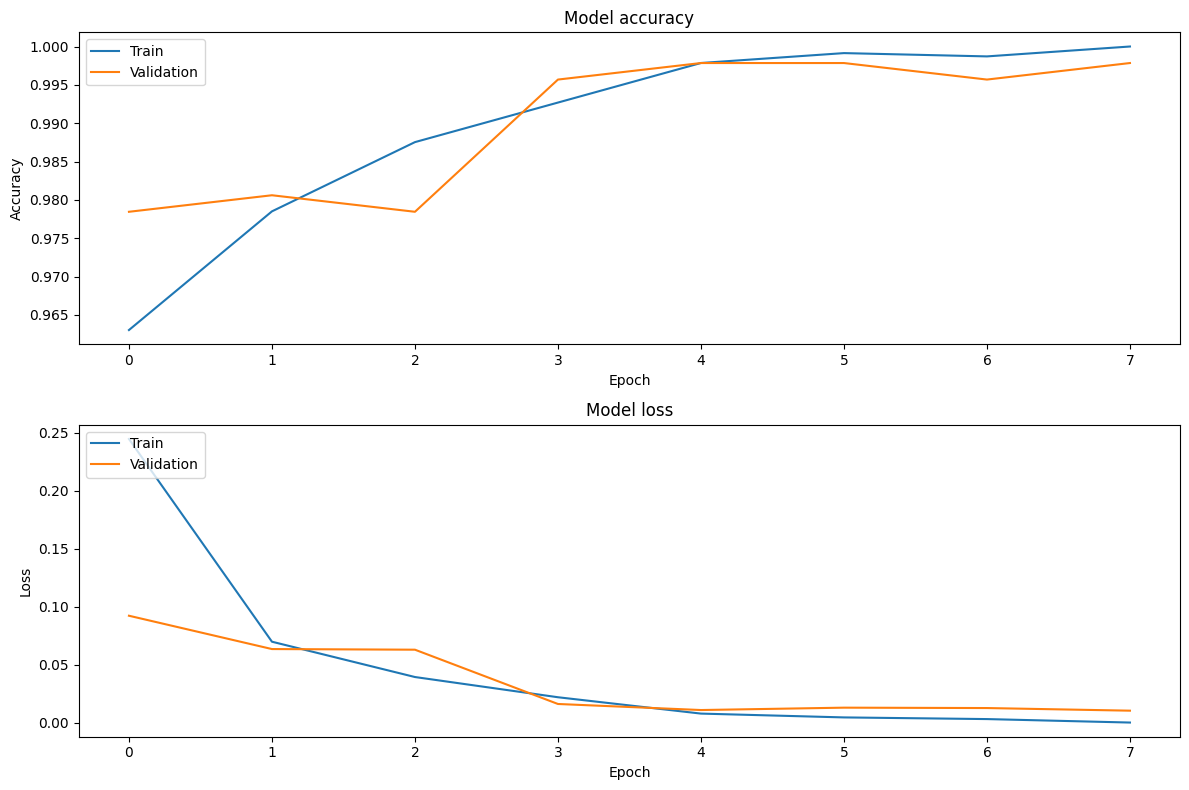

In [9]:
import matplotlib.pyplot as plt 

def plot_training_history(history):
    """Plot the training history of a model."""
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


plot_training_history(history)

---

## Generating and Analyzing Predictions on the Test Set ##

This section of the code is dedicated to generating predictions on the test set, analyzing the results, and saving the output for further inspection. Here's an overview of each step:

 **Setting Up Output Directory**:
   - The code first ensures that the output directory exists. If it doesn't, the directory is created. This is where the prediction results will be saved.
     
 **Preparing Test Data for Prediction**:
   - The test data (`test_df['Text']`) is vectorized using the previously defined `vectorizer`. This transforms the text data into a numerical format that the model can process.
   - The test labels are also prepared by mapping the 'Manifesto' label to 1 and all others to 0.
     
 **Generating Predictions**:
   - The model generates predictions for the vectorized test data. These predictions are probabilities indicating the likelihood of each text being labeled as 'Manifesto.
    
 **Processing and Mapping Predictions**:
   - The raw predictions are converted to binary values based on a threshold (commonly set at 0.5). These binary values represent the final predicted labels.
   - A label mapping is used to convert these binary predictions back to human-readable labels ('Manifesto' or 'Nil').
     
 **Constructing Results DataFrame**:
   - A DataFrame is constructed to neatly display the original text, the true label, the predicted label, and the model's confidence score for each prediction.
     
 **Identifying Incorrect Predictions**:
   - The code identifies instances where the model's predictions differ from the actual labels. This subset of data can be particularly useful for understanding the model's shortcomings.

 **Saving Predictions to Output Directory**:
   - Both the complete set of predictions and the subset of incorrect predictions are saved as CSV files in the specified output directory. These files can be used for detailed analysis or for reporting purposes.
    

This comprehensive approach to prediction and analysis is crucial for evaluating the model's performance and identifying areas for improvement. The outcome is no incorrect predicitions confirming the accuracy of the model.

---

In [10]:
import os

# Directory for saving results
output_dir = "/kaggle/working/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Prepare test data for prediction
X_test = vectorizer(np.array(test_df['Text']))  # TextVectorization on test set
y_test = test_df['Label'].apply(lambda x: 1 if x == 'Manifesto' else 0).values  # Prepare test labels

# Generate Predictions for the test set
predictions = model.predict(X_test)

# Convert predictions to binary values based on a threshold of 0.5 (change if needed)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Mapping of labels
label_mapping = {1: 'Manifesto', 0: 'Nil'}  # Adjust this mapping based on your label definitions
predicted_labels_text = [label_mapping[label] for label in predicted_labels]

# Construct the results DataFrame
result_df = pd.DataFrame({
    'Original Text': test_df['Text'],  # Use the 'Text' column from test_df
    'Original Label': [label_mapping[label] for label in y_test],  # Convert numerical labels to text
    'Predicted Label': predicted_labels_text,
    'Confidence Score': predictions.flatten() 
})

# Identify incorrect predictions
incorrect_predictions_indices = np.where(predicted_labels != y_test)[0]
incorrect_df = result_df.iloc[incorrect_predictions_indices]

# Save the incorrect predictions to output directory
incorrect_df.to_csv(os.path.join(output_dir, 'incorrect_predictions.csv'), index=False)



4/4 [==============================] - 1s 81ms/step


---

## Sources ##

**Manifestos of concern:**

In order to prevent distribution of the manifestos of concern, I have opted to make the dataset private and have ommited the titles and names of the documents. All have been publically released, and are legally avaliable under the New Zealand censorship standard. Please email Nicolasneuralnetworks@proton.me for more information if needed. 

A CSV file of the nil data has been included and made publically accessible. 

**Nil Dataset:**
* https://www.kaggle.com/datasets/kamaruladha/mental-disorders-identification-reddit-nlp
* https://www.kaggle.com/datasets/neelghoshal/reddit-mental-health-data
* https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned
* https://www.kaggle.com/datasets/gracchus/ironmarch
* https://zenodo.org/records/5559972
* https://zenodo.org/records/3606810
* https://github.com/khanbabaloo/dataset-incel/tree/main

**Nil Manifestos:**
* https://americanhumanist.org/what-is-humanism/manifesto1/
* https://assets.nationbuilder.com/beachheroes/pages/17789/attachments/original/1688864858/Final-online-PDF-pages.pdf?1688864858
* https://avac.org/project/transgender-manifesto/
* https://avac.org/wp-content/uploads/2023/03/NDNM_Manifesto.pdf
* https://cdn.mises.org/For%20a%20New%20Liberty%20The%20Libertarian%20Manifesto_3.pdf
* https://clientearth.org/media/cddjgfod/uk-manifesto-2023.pdf
* https://ergonetwork.org/wp-content/uploads/2023/10/ERGO-EU-Elections-2024-Pledge-VISUAL-Full-text-PDF-document.pdf
* https://fra.europa.eu/en/news/2022/80-roma-live-poverty
* https://liberal-international.org/who-we-are/our-mission/landmark-documents/political-manifestos/liberal-manifesto-2017/
* https://libdems.org.uk/plan
* https://lp.org/platform/
* https://reneweuropegroup.app.box.com/s/grj3jds999rhnd4i36log0bsnatmab9a
* https://resourcecentre.savethechildren.net/document/we-do-not-want-to-be-scared-any-longer-childrens-manifesto/
* https://theanarchistlibrary.org/library/elany-and-samuel-b-survival-in-the-endtimes-a-wildpunk-manifesto
* https://theyouthcafe.com/tools-and-publications/the-youth4climate-manifesto
* https://unfccc.int/sites/default/files/resource/Youth4Climate-Manifesto.pdf
* https://unicef.org/armenia/en/stories/endviolence-youth-manifesto
* https://youth.europa.eu/get-involved/democratic-participation/conference-future-of-europe-what-it_tr






